# 1d-signal smoothing using different techniques

In [1]:
%matplotlib inline
import sys
sys.path.append('../../')
from datasets import solar
import pandas as pd
import numpy as np

### load data

In [2]:
# load
data, dcol = solar.load()
# rename columns
data.rename(columns = {'DSWRF267':'s1', 'y':'s2'}, inplace=True)
# filter columns
data = data[['hour', 'doy', 's1', 's2']]

Load data..


### smoothing per hour

In [146]:
ihour = 11
# filter rows
s1 = data[data.hour == ihour][['s1']]

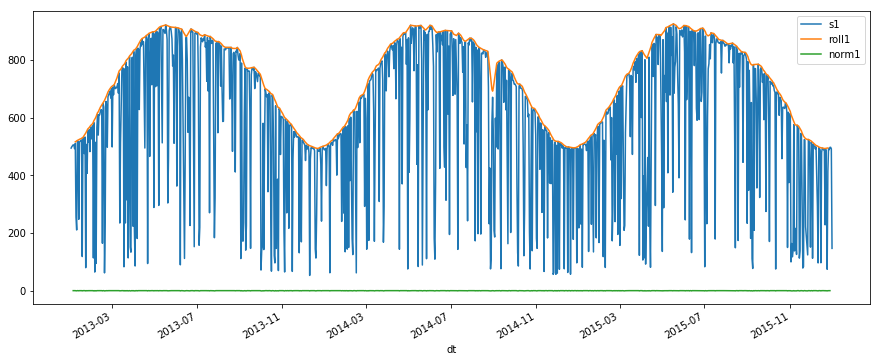

In [151]:
s1['roll1'] = s1.rolling(window=7, center=True).max()
s1['roll1'] = s1['roll1'].rolling(window=7, center=True).mean()
#s1['lp1'] = y
s1[:].plot(figsize=(15,6))

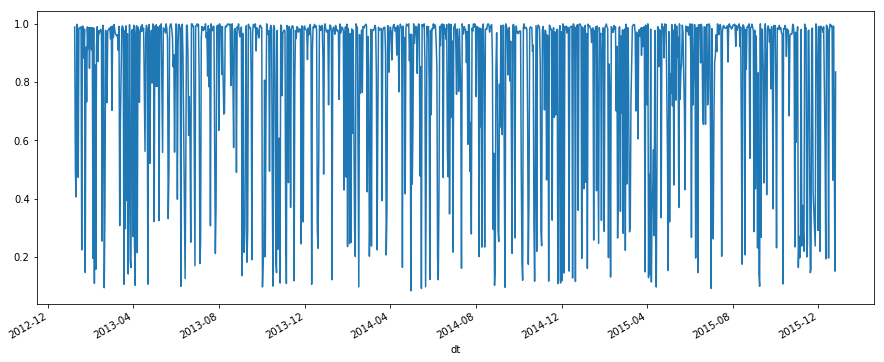

In [152]:
s1['norm1'] = s1.s1.values / s1.roll1.values
s1['norm1'].plot(figsize=(15,6))

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1c28d3b908>,
      dtype=object)

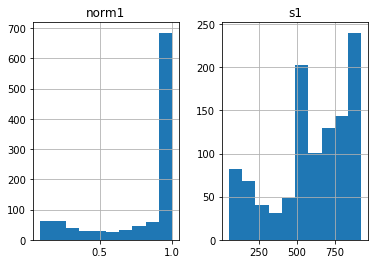

In [153]:
s1[['s1','norm1']].hist()

In [171]:
s2 = data[data.hour == ihour][['s2']]
np.max(s2.s2.values)

3299.5

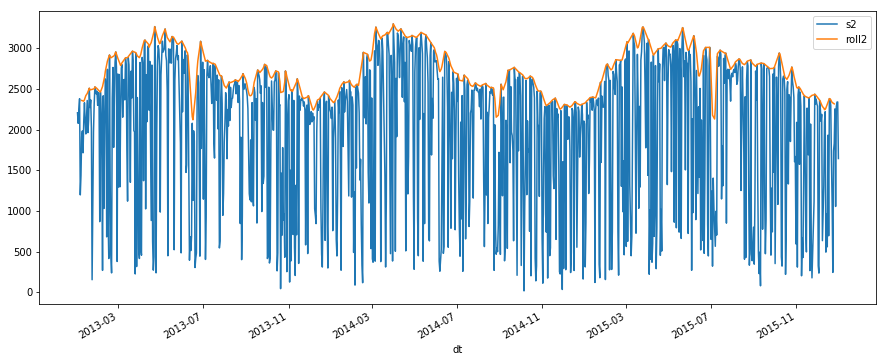

In [172]:
s2['roll2'] = s2.rolling(window=7, center=True).max()
s2['roll2'] = s2['roll2'].rolling(window=7, center=True).mean()
s2[:].plot(figsize=(15,6))

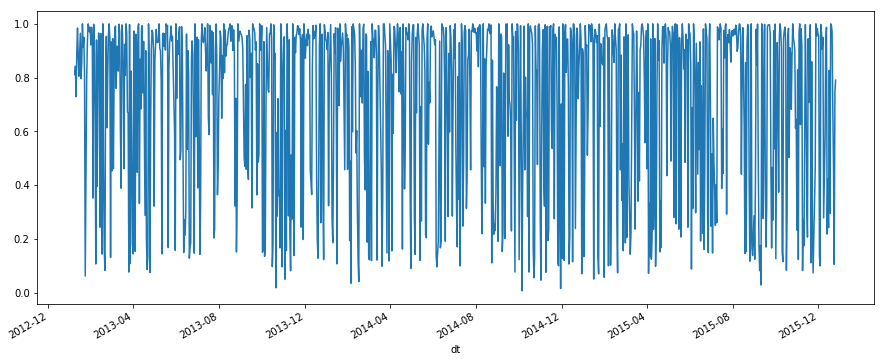

In [173]:
s2['norm2'] = s2.s2.values / s2.roll2.values
s2['norm2'].plot(figsize=(15,6))

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1c2a812668>,
      dtype=object)

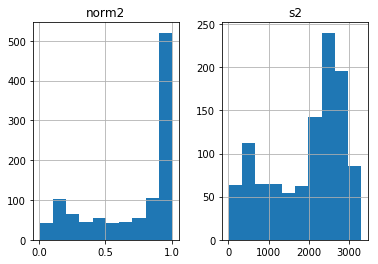

In [174]:
s2[['s2','norm2']].hist()

In [264]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing
# prepare data
df1 = data[data.hour == ihour][['s1']]
# create class
model = ExponentialSmoothing(df1.s1.values, seasonal_periods = 365)
# fit model
model_fit = model.fit()
# make prediction
df1['yhat'] = model_fit.predict(start = 0, end =len(df1)-1)

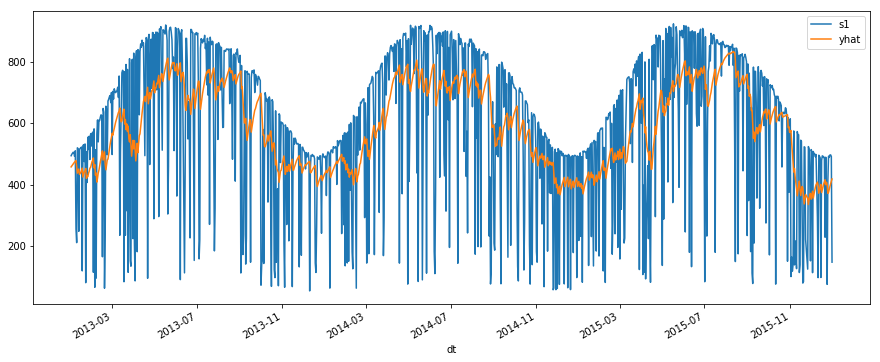

In [265]:
df1.plot(figsize=(15,6))

In [24]:
ihour = 11
df1 = data[data.hour == ihour][['doy','s1']]
train_x = df1.doy.values
train_y = df1.s1.values

In [28]:
from patsy import dmatrix
import statsmodels.api as sm
import statsmodels.formula.api as smf

# Generating cubic spline with 3 knots at 25, 40 and 60
transformed_x = dmatrix("bs(train, knots=(25,150), degree=3, include_intercept=False)", {"train": train_x},return_type='dataframe')

# Fitting Generalised linear model on transformed dataset
fit1 = sm.GLM(train_y, transformed_x).fit()

# Generating cubic spline with 4 knots
transformed_x2 = dmatrix("bs(train, knots=(25,40,50,65),degree =3, include_intercept=False)", {"train": train_x}, return_type='dataframe')

# Fitting Generalised linear model on transformed dataset
fit2 = sm.GLM(train_y, transformed_x2).fit()

# Predictions on both splines
pred1 = fit1.predict(dmatrix("bs(valid, knots=(25,150), include_intercept=False)", {"valid": train_x}, return_type='dataframe'))
pred2 = fit2.predict(dmatrix("bs(valid, knots=(25,40,50,65),degree =3, include_intercept=False)", {"valid": train_x}, return_type='dataframe'))
"""
# Calculating RMSE values
rms1 = sqrt(mean_squared_error(valid_y, pred1))
rms2 = sqrt(mean_squared_error(valid_y, pred2))

# We will plot the graph for 70 observations only
xp = np.linspace(valid_x.min(),valid_x.max(),70)

# Make some predictions
pred1 = fit1.predict(dmatrix("bs(xp, knots=(25,40,60), include_intercept=False)", {"xp": xp}, return_type='dataframe'))
pred2 = fit2.predict(dmatrix("bs(xp, knots=(25,40,50,65),degree =3, include_intercept=False)", {"xp": xp}, return_type='dataframe'))

# Plot the splines and error bands
plt.scatter(data.age, data.wage, facecolor='None', edgecolor='k', alpha=0.1)
plt.plot(xp, pred1, label='Specifying degree =3 with 3 knots')
plt.plot(xp, pred2, color='r', label='Specifying degree =3 with 4 knots')
plt.legend()
plt.xlim(15,85)
plt.ylim(0,350)
plt.xlabel('age')
plt.ylabel('wage')
plt.show()
"""

'\n# Calculating RMSE values\nrms1 = sqrt(mean_squared_error(valid_y, pred1))\nrms2 = sqrt(mean_squared_error(valid_y, pred2))\n\n# We will plot the graph for 70 observations only\nxp = np.linspace(valid_x.min(),valid_x.max(),70)\n\n# Make some predictions\npred1 = fit1.predict(dmatrix("bs(xp, knots=(25,40,60), include_intercept=False)", {"xp": xp}, return_type=\'dataframe\'))\npred2 = fit2.predict(dmatrix("bs(xp, knots=(25,40,50,65),degree =3, include_intercept=False)", {"xp": xp}, return_type=\'dataframe\'))\n\n# Plot the splines and error bands\nplt.scatter(data.age, data.wage, facecolor=\'None\', edgecolor=\'k\', alpha=0.1)\nplt.plot(xp, pred1, label=\'Specifying degree =3 with 3 knots\')\nplt.plot(xp, pred2, color=\'r\', label=\'Specifying degree =3 with 4 knots\')\nplt.legend()\nplt.xlim(15,85)\nplt.ylim(0,350)\nplt.xlabel(\'age\')\nplt.ylabel(\'wage\')\nplt.show()\n'

In [29]:
result = pd.DataFrame(np.c_[train_x,train_y, pred1, pred2], columns=['x','y','y_hat1', 'y_hat2'])

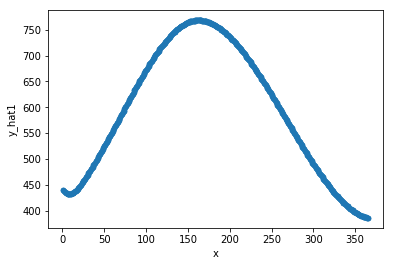

In [30]:
result.plot(x='x', y = 'y_hat1', kind = "scatter")

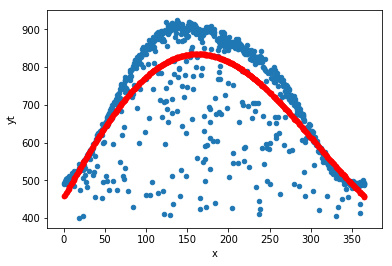

In [87]:
ihour = 11
df1 = data[data.hour == ihour][['doy','s1']]#[:365]
df1 = df1[df1.s1>400]
x = df1.doy.values
y = df1.s1.values

xt = dmatrix("bs(x, df=6, degree=5, include_intercept=True)+1", {"x": x})
fit = sm.GLM(y, xt).fit()
yt = fit.predict(dmatrix("bs(x, df=6, degree=5, include_intercept=True)+1", {"x": x}, return_type='dataframe'))

result = pd.DataFrame(np.c_[x,y, yt], columns=['x','y','yt'])
import matplotlib.pyplot as plt
fig, ax = plt.subplots()
result.plot(x='x', y = 'y', kind = "scatter", ax = ax)
result.plot(x='x', y = 'yt',kind = 'scatter', ax = ax, color = 'r')
plt.show()

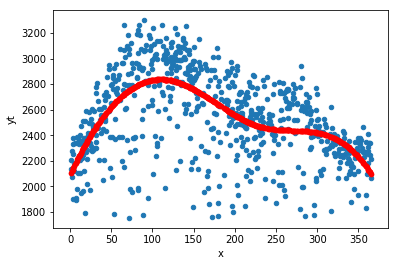

In [84]:
ihour = 11
df1 = data[data.hour == ihour][['doy','s2']]#[:365]
df1 = df1[df1.s2>1750]
x = df1.doy.values
y = df1.s2.values

xt = dmatrix("bs(x, df=6, degree=3, include_intercept=True)+1", {"x": x})
fit = sm.GLM(y, xt).fit()
yt = fit.predict(dmatrix("bs(x, df=6, degree=3, include_intercept=True)+1", {"x": x}, return_type='dataframe'))

result = pd.DataFrame(np.c_[x,y, yt], columns=['x','y','yt'])
import matplotlib.pyplot as plt
fig, ax = plt.subplots()
result.plot(x='x', y = 'y', kind = "scatter", ax = ax)
result.plot(x='x', y = 'yt',kind = 'scatter', ax = ax, color = 'r')
plt.show()

In [ ]:
https://github.com/dswah/pyGAM